In this notebook we will fine tune BERT Transformer model from Hugging Face on the custom dataset for detecting comments as Toxic or non-Toxic.

In [65]:
%%capture
!pip install transformers

In [66]:
import pandas as pd
import torch
import numpy as np
import re
import string
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
data = pd.read_csv("/content/drive/MyDrive/toxic_comments_train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [69]:
len(data)

159571

Let's do a basic pre-processing of the comment text

In [70]:
def clean_text(text):
    '''Remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', ' ', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)
    
    return text

data['comment_text'] = data['comment_text'].apply(clean_text)

In [71]:
for text in data['comment_text'][0:5]:
  print(text, '\n')

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired  

Daww He matches this background colour Im seemingly stuck with Thanks  talk  January   UTC 

Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info 

 More I cant make any real suggestions on improvement  I wondered if the section statistics should be later on or a subsection of types of accidents  I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if noone else does first  if you have any preferences for formatting style on references or want to do it yourself please let me know  There appears to be

<Axes: >

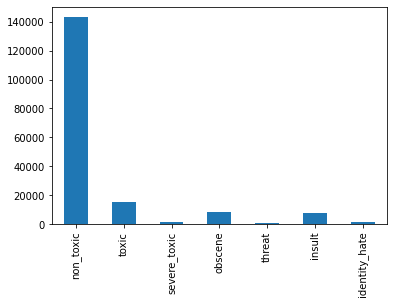

In [72]:
data['non_toxic'] = data['toxic']+data['severe_toxic']+data['obscene']+data['threat']+data['insult']+data['identity_hate']

# We will change the value to 1 (meaning non toxic) if the value is 0 and set it to 0 for all other cases
data['non_toxic'] = data['non_toxic'].apply(lambda x: 1 if x==0 else 0)

data[['non_toxic','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot.bar()

We can clearly see that the dataset is highly imbalanced. Let's make the training dataset balanced. We will club all categories that are other than Non-Toxic into the Toxic umbrella category.

In [73]:
data['toxic'] = np.where(data['non_toxic']==1, 0, 1)

# We only need comments and label columns 
data = data[['comment_text', 'toxic']]   

data_toxic = data[data['toxic']==1]
data_nontoxic = data[data['toxic']==0]
data = pd.concat([data_toxic, data_nontoxic.head(len(data_toxic))], axis=0)
print(data['toxic'].value_counts())

X = list(data['comment_text'])
y = list(data['toxic'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=40)

1    16225
0    16225
Name: toxic, dtype: int64


In [74]:
# Let's keep a separate portion for the test set from the validation set

X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=40)

Now let's define the Dataset class

In [75]:
# Creating the tokenizer object. Using bert-base-cased since I believe comments in all-caps could have a distinct meaning
checkpoint = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(checkpoint)

class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, y):

        self.labels = y
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt") for text in X]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        texts = self.texts[idx]
        label = np.array(self.labels[idx])
        return texts, label

Now let's define the BERT Classifier

In [76]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)  # Since we have 2 classes in the Label
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):

        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

Now let's create a training function to train the model

In [77]:
def train(model, X_train, y_train, X_val, y_val, learning_rate, epochs):

    train = Dataset(X_train, y_train)
    val = Dataset(X_val, y_val)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    loss = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    cuda_available = torch.cuda.is_available()
    device = torch.device("cuda" if cuda_available else "cpu")    

    if cuda_available:

            model = model.cuda()
            loss = loss.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                attention_mask = train_input['attention_mask'].to(device)
                input_ids = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_ids, attention_mask)
                
                batch_loss = loss(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                accuracy = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += accuracy

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    attention_mask = val_input['attention_mask'].to(device)
                    input_ids = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_ids, attention_mask)

                    batch_loss = loss(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    accuracy = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += accuracy
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(y_train): .3f} | Train Accuracy: {total_acc_train / len(y_train): .3f} | Val Loss: {total_loss_val / len(y_val): .3f} | Val Accuracy: {total_acc_val / len(y_val): .3f}')
     

Now let's create the evaluation function to test the model performance on the test set.

In [78]:
def evaluate(model, X_test, y_test):

    test = Dataset(X_test, y_test)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32)

    cuda_available = torch.cuda.is_available()
    device = torch.device("cuda" if cuda_available else "cpu")

    if cuda_available:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              attention_mask = test_input['attention_mask'].to(device)
              input_ids = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_ids, attention_mask)

              accuracy = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += accuracy
    
    print(f'Test Accuracy: {total_acc_test / len(y_test): .3f}')

Let's train the model now

In [79]:
EPOCHS = 2
LR = 1e-5
model = BertClassifier()        
train(model, X_train, y_train, X_val, y_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1522/1522 [35:28<00:00,  1.40s/it]


Epochs: 1 | Train Loss:  0.014 | Train Accuracy:  0.893 | Val Loss:  0.012 | Val Accuracy:  0.923


100%|██████████| 1522/1522 [35:27<00:00,  1.40s/it]


Epochs: 2 | Train Loss:  0.007 | Train Accuracy:  0.959 | Val Loss:  0.013 | Val Accuracy:  0.925


In [80]:
# Evaluating the model on the test set

evaluate(model, X_test, y_test)

Test Accuracy:  0.930


Let's try out the model with some sample comments

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample = ["You are stupid enough to go there alone.", 
          "I am going home", 
          "fuck you!!", 
          "I love you more everyday.", 
          "I loved you but not anymore since I am now over you, so kindly leave me alone.",
          "This course is shit! I'd rather learn on my own..."]

input = tokenizer(sample, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

attention_mask = input['attention_mask'].to(device)
input_ids = input['input_ids'].squeeze(1).to(device)
logits = model(input_ids, attention_mask)

# Printing the model output logits
print(logits)

In [84]:
# Let's convert the model output logits into probabilites by passing them through the Softmax function
predictions = torch.nn.functional.softmax(logits, dim=-1)
print(predictions)
preds_array = predictions.detach().cpu().numpy()

# Displaying the model predictions
for i, pred in enumerate(preds_array):
  if pred[0] > pred[1]:
    print("\nComment:", sample[i],"\nPrediction: Not Toxic", "\nProbability:", pred[0])
  else:
    print("\nComment:", sample[i],"\nPrediction: Toxic", "\nProbability:", pred[1])


tensor([[0.0019, 0.9981],
        [0.9635, 0.0365],
        [0.0013, 0.9987],
        [0.9292, 0.0708],
        [0.8705, 0.1295],
        [0.0026, 0.9974]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Comment: You are stupid enough to go there alone. 
Prediction: Toxic 
Probability: 0.99808514

Comment: I am going home 
Prediction: Not Toxic 
Probability: 0.96353376

Comment: fuck you!! 
Prediction: Toxic 
Probability: 0.99870527

Comment: I love you more everyday. 
Prediction: Not Toxic 
Probability: 0.9291661

Comment: I loved you but not anymore since I am now over you, so kindly leave me alone. 
Prediction: Not Toxic 
Probability: 0.87054634

Comment: This course is shit! I'd rather learn on my own... 
Prediction: Toxic 
Probability: 0.9973973


In [85]:
PATH = '/content/drive/MyDrive/toxic_comm_classifier.pt'
torch.save(model.state_dict(), PATH)